# **Memory and CPU Efficiency in Solving Simple ODEs**

## **Introduction**
When solving ordinary differential equations (ODEs) numerically, memory usage and precision directly influence computational efficiency and accuracy. The choice between **float32 and float64** affects both speed and numerical stability, particularly in **long-term simulations or stiff systems**.

This document examines how memory precision affects the solution of a **simple first-order ODE**, and how memory usage, CPU load, and computational time differ between float32 and float64 implementations.

---

## **1️ The Simple ODE: Exponential Decay**
We consider the **exponential decay equation**:
$$
\frac{dy}{dt} = -ky
$$
where:
- $ y(t) $ represents a decaying quantity.
- $ k $ is a decay constant.

This equation models phenomena such as **radioactive decay, cooling processes, and population decline**. Its exact solution is given by:
$$
 y(t) = y_0 e^{-kt}
$$
where $ y_0 $ is the initial value.

We solve this equation numerically using **Scipy’s `solve_ivp`** with different precision levels.

---

## **2️ Memory Precision: Float32 vs. Float64**
Computers represent floating-point numbers using different precisions:
| **Precision** | **Memory Usage per Number** | **Advantages** | **Disadvantages** |
|-------------|----------------------|--------------|----------------|
| **float32** | 4 bytes | Faster, lower memory | Lower precision, more rounding errors |
| **float64** | 8 bytes | Higher accuracy | Slower, higher memory usage |

For simple ODEs, **float32 may be sufficient**, but long-term simulations could suffer from accumulated rounding errors.

---

## **3️ Impact of Memory on Numerical Solutions**
### **Memory Usage Considerations**
1. **Float32 requires 50% less memory than Float64**, which is beneficial in large-scale simulations.
2. **Lower precision may introduce truncation errors over long time intervals.**
3. **Higher memory bandwidth for float64 computations** can slow down performance.

### **Computational Efficiency**
- **Float32 is typically faster** due to reduced memory bandwidth usage.
- **Float64 offers more precision**, avoiding long-term drift in solutions.
- **CPU load is often higher for float64 computations**.

---

## **4️ Visualization and Memory Profiling**
To analyze performance, we generate:
1. **Solution Comparison**: How float32 and float64 results compare.
2. **Memory Usage Plot**: Total memory consumption for each precision level.
3. **Computation Time**: Execution speed for each precision.
4. **CPU Usage**: How much CPU power is used in each case.

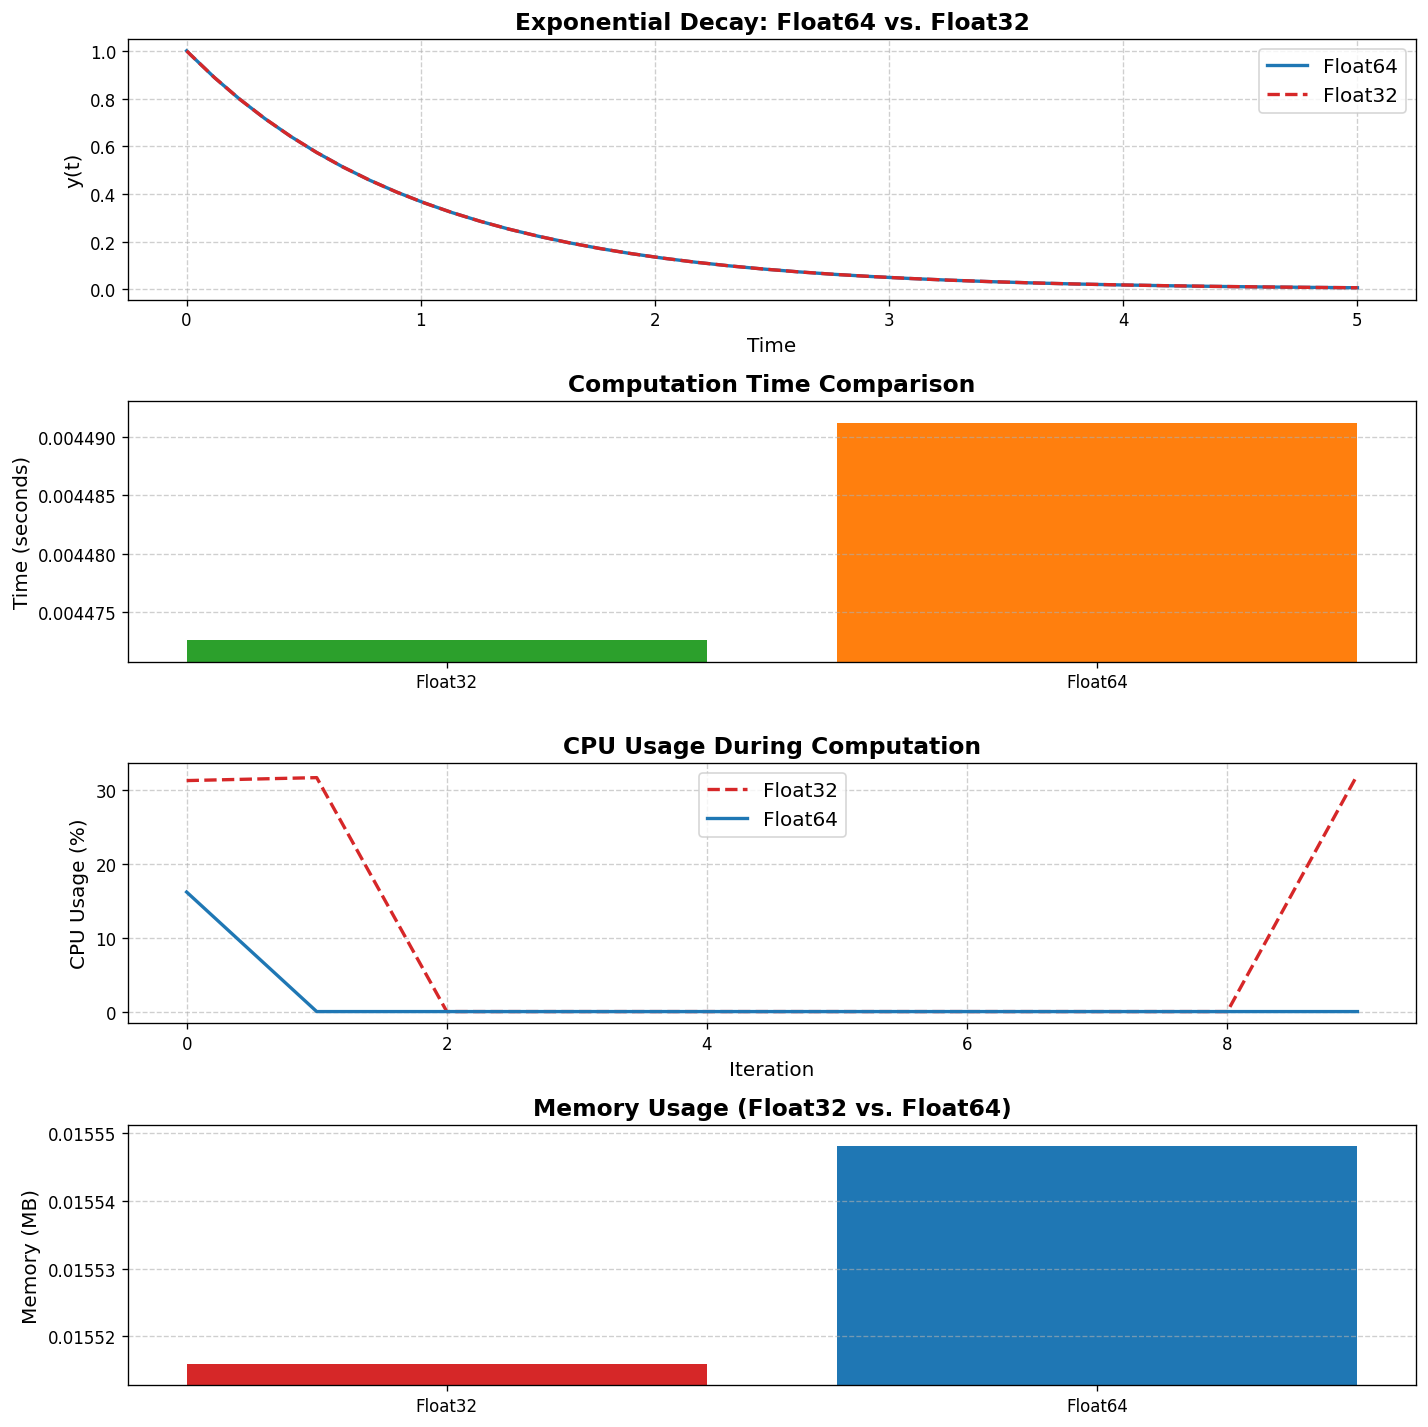

In [2]:
import tracemalloc
import numpy as np
import matplotlib.pyplot as plt
import psutil
import time
import gc
from scipy.integrate import solve_ivp

# Force garbage collection before tracking memory
gc.collect()

# Start memory tracking
tracemalloc.start()

# Define the simple exponential decay ODE
def exp_decay(t, y, k=np.float32(1.0)):  # Ensure k is also Float32-compatible
    return -k * y

# Solve once to warm up caches and avoid first-run biases
solve_ivp(exp_decay, [0, 5], np.array([1.0], dtype=np.float64), method='RK45', atol=1e-8, rtol=1e-8)

# ---------------------------- Float64 Computation ----------------------------
gc.collect()  # Clear previous allocations
tracemalloc.reset_peak()

start_mem_64 = tracemalloc.get_traced_memory()[0]
start_time_64 = time.perf_counter()
sol_64 = solve_ivp(exp_decay, [0, 5], np.array([1.0], dtype=np.float64), 
                    method='RK45', atol=1e-8, rtol=1e-8, dense_output=False)
time_64 = time.perf_counter() - start_time_64
mem_64 = tracemalloc.get_traced_memory()[1] - start_mem_64  # Peak memory for Float64

# ---------------------------- Float32 Computation ----------------------------
gc.collect()  # Clear previous allocations
tracemalloc.reset_peak()

start_mem_32 = tracemalloc.get_traced_memory()[0]
start_time_32 = time.perf_counter()
sol_32 = solve_ivp(exp_decay, [0, 5], np.array([1.0], dtype=np.float32), 
                    method='RK45', atol=np.float32(1e-8), rtol=np.float32(1e-8), dense_output=False)
time_32 = time.perf_counter() - start_time_32
mem_32 = tracemalloc.get_traced_memory()[1] - start_mem_32  # Peak memory for Float32

# Convert solution values to Float32 to avoid any hidden Float64 data
sol_32.y = sol_32.y.astype(np.float32)

# Stop memory tracking
current_memory, peak_memory = tracemalloc.get_traced_memory()
tracemalloc.stop()

# ---------------------------- CPU Usage Tracking ----------------------------
cpu_usage_32 = []
cpu_usage_64 = []

# Measure CPU usage for Float64
for _ in range(10):
    _ = solve_ivp(exp_decay, [0, 5], np.array([1.0], dtype=np.float64), 
                  method='RK45', atol=1e-8, rtol=1e-8, dense_output=False)
    cpu_usage_64.append(psutil.cpu_percent(interval=0.1))

# Measure CPU usage for Float32
for _ in range(10):
    _ = solve_ivp(exp_decay, [0, 5], np.array([1.0], dtype=np.float32), 
                  method='RK45', atol=np.float32(1e-8), rtol=np.float32(1e-8), dense_output=False)
    cpu_usage_32.append(psutil.cpu_percent(interval=0.1))

# ---------------------------- Plotting ----------------------------
fig, axs = plt.subplots(4, 1, figsize=(12, 12), dpi=120)

# Solution plot
axs[0].plot(sol_64.t, sol_64.y[0], label="Float64", linestyle="-", linewidth=2, color="tab:blue")
axs[0].plot(sol_32.t, sol_32.y[0], label="Float32", linestyle="--", linewidth=2, color="tab:red")
axs[0].set_title("Exponential Decay: Float64 vs. Float32", fontsize=14, fontweight='bold')
axs[0].set_xlabel("Time", fontsize=12)
axs[0].set_ylabel("y(t)", fontsize=12)
axs[0].legend(fontsize=12)
axs[0].grid(True, linestyle="--", alpha=0.6)

# Dynamic scaling function for better bar plot contrast
def set_bar_ylim(ax, values, padding=0.1):
    min_val, max_val = min(values), max(values)
    range_val = max_val - min_val
    lower = min_val - (range_val * padding) if min_val > 0 else min_val * 0.8
    upper = max_val + (range_val * padding)
    ax.set_ylim(lower, upper)

# Computation time plot (scaled y-axis)
axs[1].bar(["Float32", "Float64"], [time_32, time_64], color=["tab:green", "tab:orange"])
axs[1].set_title("Computation Time Comparison", fontsize=14, fontweight='bold')
axs[1].set_ylabel("Time (seconds)", fontsize=12)
set_bar_ylim(axs[1], [time_32, time_64])
axs[1].grid(axis='y', linestyle="--", alpha=0.6)

# CPU usage plot
axs[2].plot(cpu_usage_32, label="Float32", linestyle="--", linewidth=2, color="tab:red")
axs[2].plot(cpu_usage_64, label="Float64", linestyle="-", linewidth=2, color="tab:blue")
axs[2].set_title("CPU Usage During Computation", fontsize=14, fontweight='bold')
axs[2].set_xlabel("Iteration", fontsize=12)
axs[2].set_ylabel("CPU Usage (%)", fontsize=12)
axs[2].legend(fontsize=12)
axs[2].grid(True, linestyle="--", alpha=0.6)

# Memory usage plot (scaled y-axis)
axs[3].bar(["Float32", "Float64"], [mem_32 / 1e6, mem_64 / 1e6], color=["tab:red", "tab:blue"])
axs[3].set_title("Memory Usage (Float32 vs. Float64)", fontsize=14, fontweight='bold')
axs[3].set_ylabel("Memory (MB)", fontsize=12)
set_bar_ylim(axs[3], [mem_32 / 1e6, mem_64 / 1e6])
axs[3].grid(axis='y', linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()